In [1]:
import time
import matplotlib

import SwarmStartleLooming as sw
import numpy as np
import matplotlib.pyplot as plt

In [246]:
#np.random.seed(200)
# Initialize Parameters
N = 40
L = 50
total_time = 500.0
dt = 0.001

speed0 = 2.5
alpha = 0.8
noisep = 0.01
noisev = 0.05
BC = 0 #'along_wall'
IC = 10 # initial condition

repstrength = 1.0
algstrength = 0.5
attstrength = 0.3

reprange = 1.0
algrange = 5.0
attrange = 25.0

repsteep = -20

output = 0.5

int_type = 'matrix'
startle = True

amplitude_startle = 5.0
duration_startle = 1.0
# initialize system parameters
paraSystem = sw.BaseParams(N=N, L=L, time=total_time, dt=dt, BC=BC, IC=IC, output=output, int_type=int_type, startle=startle)
# initialize prey parameters
paraFish = sw.AgentParams(paraSystem, speed0=speed0, alpha=alpha,
                          repstrength=repstrength, reprange=reprange, repsteepness=repsteep,
                          algstrength=algstrength, algrange=algrange,
                          attstrength=attstrength, attrange=attrange,
                          noisep=noisep, noisev=noisev,
                          amplitude_startle=amplitude_startle,
                          duration_startle=duration_startle,
                          r_m=10*1e6,
                          tau_m=0.023,
                          e_l=-0.079,
                          v_t=-0.061,
                          vt_std=0.001,
                          tau_rho=0.001,
                          rho_null=2,
                          rho_null_std=1.2,
                          rho_scale=9.6 * 1e6,
                          exc_scale=40,
                          noise_std_exc=0.010,
                          noise_std_inh=0.005,
                          vis_input_m=3,
                          vis_input_b=0,
                          vis_input_method='max',
                          vis_input_k=3
                          )

#outData, agentData = sw.RunAnimate(paraSystem, paraFish)
#outData, agentData = sw.RunAnimateWithStartlePotential(paraSystem, paraFish)

#starttime = time.time()

outData, agentData = sw.SingleRun(paraSystem, paraFish)

startles = np.array(outData['startle'])


#endtime = time.time()
#print('Total time needed: ' + str(int((endtime - starttime))) + ' seconds or '
#      + str(int((endtime - starttime) / 60)) + ' min')

/home/warkentin/Dropbox/Master/thesis/code/SwarmStartleLooming.py:525: RuntimeWarning: invalid value encountered in true_divide
  dUX = np.divide(dX, distmatrix)
/home/warkentin/Dropbox/Master/thesis/code/SwarmStartleLooming.py:526: RuntimeWarning: invalid value encountered in true_divide
  dUY = np.divide(dY, distmatrix)


Individual 2 startles!!!!
Individual 19 startles!!!!
Individual 5 startles!!!!
Individual 6 startles!!!!
Individual 14 startles!!!!
Individual 16 startles!!!!
Individual 29 startles!!!!
Individual 36 startles!!!!
Individual 9 startles!!!!
Individual 28 startles!!!!
Individual 3 startles!!!!
Individual 29 startles!!!!
Individual 4 startles!!!!
Individual 14 startles!!!!
Individual 15 startles!!!!
Individual 20 startles!!!!
Individual 30 startles!!!!
Individual 31 startles!!!!
Individual 3 startles!!!!
Individual 6 startles!!!!
Individual 9 startles!!!!
Individual 11 startles!!!!
Individual 26 startles!!!!
Individual 28 startles!!!!
Individual 29 startles!!!!
Individual 37 startles!!!!
Individual 38 startles!!!!
Individual 16 startles!!!!
Individual 17 startles!!!!
Individual 25 startles!!!!
Individual 33 startles!!!!
Individual 14 startles!!!!
Individual 29 startles!!!!
Individual 2 startles!!!!
Individual 14 startles!!!!
Individual 18 startles!!!!
Individual 32 startles!!!!
Individual 

# Distance from center of mass

In [109]:
def CalcDistVecMatrix(pos, L, BC):
    """ Calculate N^2 distance matrix (d_ij)

        Returns:
        --------
        distmatrix - matrix of all pairwise distances (NxN)
        dX - matrix of all differences in x coordinate (NxN)
        dY - matrix of all differences in y coordinate (NxN)
    """
    X = np.reshape(pos[:, 0], (-1, 1))
    Y = np.reshape(pos[:, 1], (-1, 1))
    dX = np.subtract(X, X.T)
    dY = np.subtract(Y, Y.T)
    dX_period = np.copy(dX)
    dY_period = np.copy(dY)
    if BC == 0:
        dX_period[dX > +0.5 * L] -= L
        dY_period[dY > +0.5 * L] -= L
        dX_period[dX < -0.5 * L] += L
        dY_period[dY < -0.5 * L] += L
    distmatrix = np.sqrt(dX_period ** 2 + dY_period ** 2)
    return distmatrix, dX_period, dY_period


def PeriodicDist(x, y, L=10.0, dim=2):
    """ Returns the distance vector of two position vectors x,y
        by tanking periodic boundary conditions into account.

        Input parameters: L - system size, dim - number of dimensions
    """
    distvec = (y - x)
    distvec_periodic = np.copy(distvec)
    distvec_periodic[distvec < -0.5 * L] += L
    distvec_periodic[distvec > 0.5 * L] -= L

    return distvec_periodic


def calcCohesion(pos, method='nearest'):
    from scipy.spatial import ConvexHull
    ntimesteps = pos.shape[0]
    coh = np.empty(ntimesteps)
    for t in np.arange(ntimesteps):
        if method == 'nearest':
            dist_mat, dx, dy = CalcDistVecMatrix(pos[t, :, :], L, BC)
            np.fill_diagonal(dist_mat, np.inf)
            min_dists = np.min(dist_mat, axis=0)
            current_cohesion = np.mean(min_dists)
        elif method == 'convexhull':
            hull = ConvexHull(pos[t, :, :])
            # volume is referring to a 3D setting so in a 2D case it gives the area
            current_cohesion = hull.volume
        elif method == 'inter':
            dist_mat, dx, dy = CalcDistVecMatrix(pos[t, :, :], L, BC)
            np.fill_diagonal(dist_mat, np.nan)
            mean_dists = np.nanmean(dist_mat, axis=0)
            current_cohesion = np.mean(mean_dists)
        else:
            current_cohesion = 0
        coh[t] = current_cohesion
    return coh


def calc_periodic_mass_center(pos, arena_size):
    periodic_center = np.zeros(2)
    norm_term = 2*np.pi/arena_size
    for dim_idx in range(2):
        circ_coords = np.zeros((pos.shape[0], 2))
        circ_coords[:, 0] = np.cos((pos[:, dim_idx] * norm_term)) / norm_term
        circ_coords[:, 1] = np.sin((pos[:, dim_idx] * norm_term)) / norm_term
        mean_circ_coords = np.mean(circ_coords, axis=0)
        mean_angle = np.arctan2(-mean_circ_coords[1], -mean_circ_coords[0]) + np.pi
        periodic_center[dim_idx] = mean_angle/norm_term
    return periodic_center


def calcStartlePosition(pos, startles, burn_period = 50, cohesion_measures=None):
    burn_period_steps = int(burn_period/output)
    startle_dists = np.array([])
    startle_distvecs = None
    for t in np.arange(burn_period_steps, ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        if startle_idc.size == 0:
            continue
        else:
            cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
            center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
            if cohesion_measures is not None:
                center_distvecs = center_distvecs/cohesion_measures[t]
                
            center_dists = np.sqrt(center_distvecs[:, 0] ** 2 + center_distvecs[:, 1] ** 2)

            startle_dists = np.concatenate((startle_dists, center_dists[startle_idc]))
            if startle_distvecs is None:
                startle_distvecs = center_distvecs[startle_idc]
            else:
                startle_distvecs = np.concatenate((startle_distvecs, center_distvecs[startle_idc]))
    return startle_dists, startle_distvecs

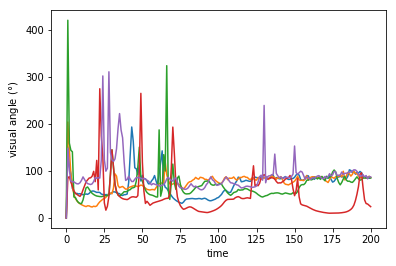

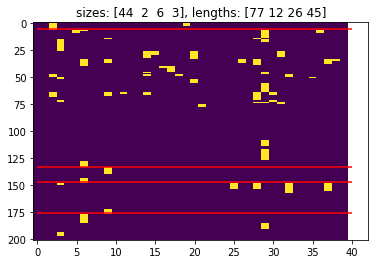

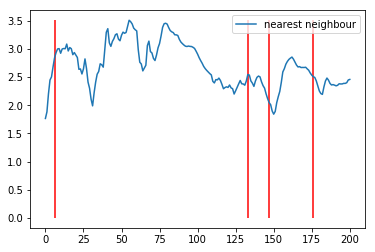

In [248]:
vis_angles = np.array(outData['vis_angles'])
plt.figure()
plt.plot(vis_angles[:, 0:5])
plt.xlabel('time')
plt.ylabel('visual angle ($\degree$)')
plt.show()

plt.figure()
szs, lens, starts = calcCascadeSizes(startles)
plt.imshow(startles, interpolation='none', aspect='auto')
plt.hlines(starts, 0, 40, colors='r')
plt.title('sizes: ' + str(szs) + ', lengths: ' + str(lens))
plt.show()

conv_coh = calcCohesion(np.array(outData['pos']), method='convexhull')
nn_coh = calcCohesion(np.array(outData['pos']), method='nearest')
ii_coh = calcCohesion(np.array(outData['pos']), method='inter')

conv_max = np.max(conv_coh)
nn_max = np.max(nn_coh)
ii_max = np.max(ii_coh)

plt.figure()
#plt.plot(conv_coh, label='convex hull')
plt.plot(nn_coh, label='nearest neighbour')
#plt.plot(ii_coh, label='inter-individual')
plt.vlines(starts, 0, nn_max, colors='r')
plt.legend()
plt.show()

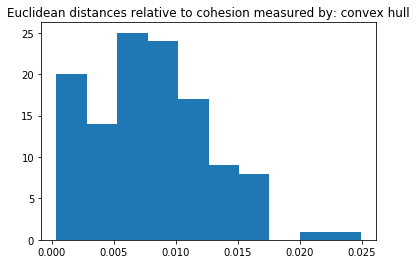

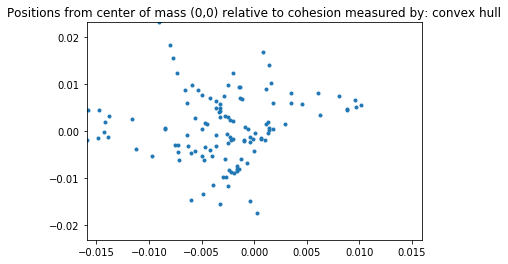

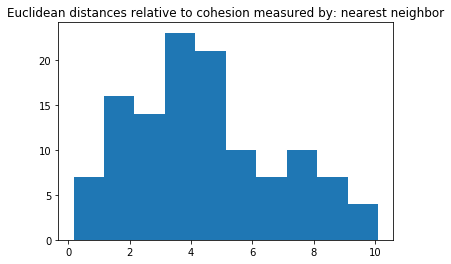

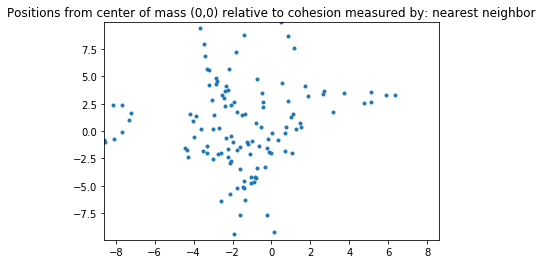

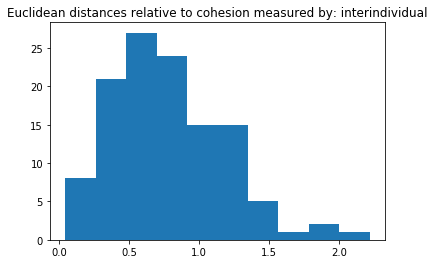

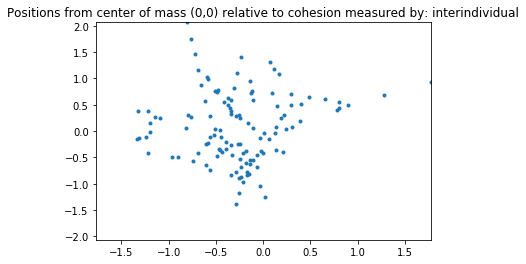

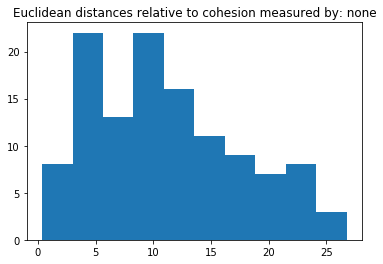

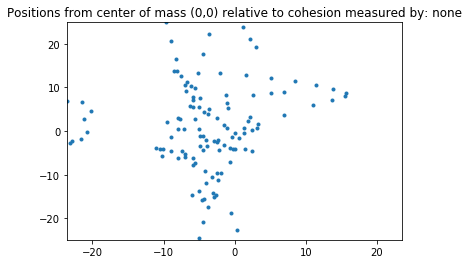

In [249]:
pos = np.array(outData['pos'])
burn_period = 30
coh_methods = ['convex hull', 'nearest neighbor', 'interindividual', 'none']
for coh_idx, coh_values in enumerate([conv_coh, nn_coh, ii_coh, None]):
    startle_dists, startle_distvecs = calcStartlePosition(pos, startles, burn_period, coh_values)
    plt.figure()
    plt.hist(startle_dists)
    plt.title('Euclidean distances relative to cohesion measured by: ' + coh_methods[coh_idx])

    plt.figure()
    plt.plot(startle_distvecs[:, 0], startle_distvecs[:, 1], '.')
    xmin = np.min(startle_distvecs[:, 0])
    xmax = np.max(startle_distvecs[:, 0])
    xmax_abs = np.max(np.abs([xmin, xmax]))
    ymin = np.min(startle_distvecs[:, 1])
    ymax = np.max(startle_distvecs[:, 1])
    ymax_abs = np.max(np.abs([ymin, ymax]))
    plt.xlim([-xmax_abs, xmax_abs])
    plt.ylim([-ymax_abs, ymax_abs])
    plt.title('Positions from center of mass (0,0) relative to cohesion measured by: ' + coh_methods[coh_idx])
plt.show()

# Orientation of school

In [250]:
uw = np.array(outData['uw'])
pos = np.array(outData['pos'])

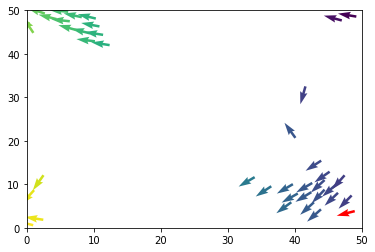

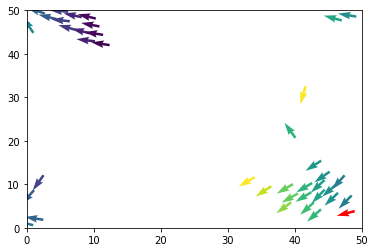

In [251]:
t = 140
cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
mean_uw = np.mean(uw[t, :, :], axis=0)
mean_uw_unit = mean_uw/np.linalg.norm(mean_uw)
mean_uw_projections = pos[t, :, 0]*mean_uw_unit[0] + pos[t, :, 1]*mean_uw_unit[1]
centered_mean_uw_projections = center_distvecs[:, 0]*mean_uw_unit[0] + center_distvecs[:, 1]*mean_uw_unit[1]

plt.figure()
plt.quiver(pos[t, :, 0], pos[t, :, 1], uw[t, :, 0], uw[t, :, 1], mean_uw_projections, cmap='viridis')
plt.xlim([0, L])
plt.ylim([0, L])

cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
plt.quiver(cmass_center[0], cmass_center[1], mean_uw[0], mean_uw[1], color='r')
plt.show()

plt.figure()
plt.quiver(pos[t, :, 0], pos[t, :, 1], uw[t, :, 0], uw[t, :, 1], centered_mean_uw_projections, cmap='viridis')
plt.xlim([0, L])
plt.ylim([0, L])

cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
plt.quiver(cmass_center[0], cmass_center[1], mean_uw[0], mean_uw[1], color='r')
plt.show()

In [252]:
startle_dists.shape

(119,)

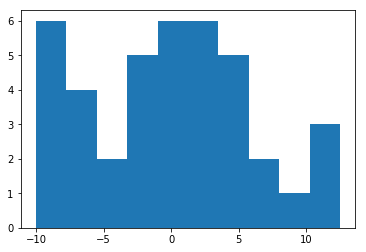

In [253]:
plt.hist(centered_mean_uw_projections)
plt.show()

In [254]:
np.max(mean_uw_projections)

-1.0723363919123043

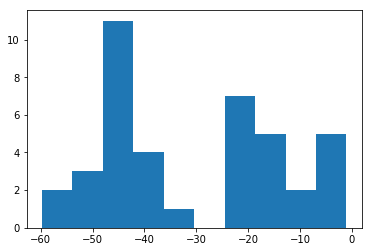

In [255]:
plt.hist(mean_uw_projections)
plt.show()

In [193]:
def calcPolarization(direction_vecs):
    """
    Calculates the group polarization.

    We use the definition by Couzin et. al 2002 here:
    p_group(t) = 1/N * |sum from {i=1} to {N} (v_i(t)|

    where N is the number of agents and v_i is a unit direction vector.

    :param outData:
        The simulation output as defined in SwarmStartle.
    :return:
    """
    mean_ux = np.mean(direction_vecs[:, :, 0], axis=1)
    mean_uy = np.mean(direction_vecs[:, :, 1], axis=1)
    return np.sqrt(mean_ux**2 + mean_uy**2)


def calcStartleOrientation(uw, pos, startles, burn_period = 50):
    burn_period_steps = int(burn_period/output)
    all_orientations = np.array([])
    all_frontness = np.array([])
    startle_orientations = np.array([])
    startle_frontness = np.array([])
    for t in np.arange(burn_period_steps, ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        if startle_idc.size == 0:
            continue
        else:
            cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
            center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
            
            mean_uw = np.mean(uw[t, :, :], axis=0)
            mean_uw_unit = mean_uw/np.linalg.norm(mean_uw)
            frontness_vals = center_distvecs[:, 0]*mean_uw_unit[0] + center_distvecs[:, 1]*mean_uw_unit[1]
            orientations = uw[t, :, 0]*mean_uw_unit[0] + uw[t, :, 1]*mean_uw_unit[1]
            
            all_orientations = np.concatenate((all_orientations, orientations))
            all_frontness = np.concatenate((all_frontness, frontness_vals))
            
            startle_orientations = np.concatenate((startle_orientations, orientations[startle_idc]))
            startle_frontness = np.concatenate((startle_frontness, frontness_vals[startle_idc]))
    return startle_orientations, startle_frontness, all_orientations, all_frontness

In [256]:
startle_orientations, startle_frontness, all_orientations, all_frontness = calcStartleOrientation(uw, pos, startles, burn_period)

In [257]:
all_orientations.shape

(3240,)

In [258]:
startle_frontness.shape

(119,)

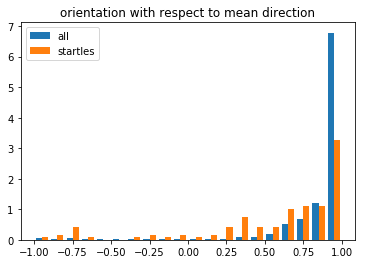

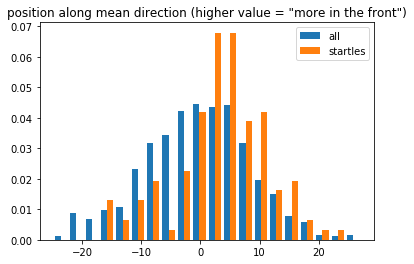

In [259]:
plt.figure()
plt.hist([all_orientations, startle_orientations], bins=20, density=True, label=['all','startles'])
plt.title('orientation with respect to mean direction')
plt.legend()

plt.figure()
plt.hist([all_frontness,startle_frontness], bins=20, density=True, label=['all','startles'])
plt.title('position along mean direction (higher value = "more in the front")')
plt.legend()
plt.show()

In [260]:
startle_orientations.shape

(119,)

In [261]:
startle_dists.shape

(119,)

In [243]:
import pandas as pd
import seaborn as sns

In [262]:
result_dict = {'dist': startle_dists, 'orientation': startle_orientations, 'frontness': startle_frontness}
df = pd.DataFrame(result_dict)

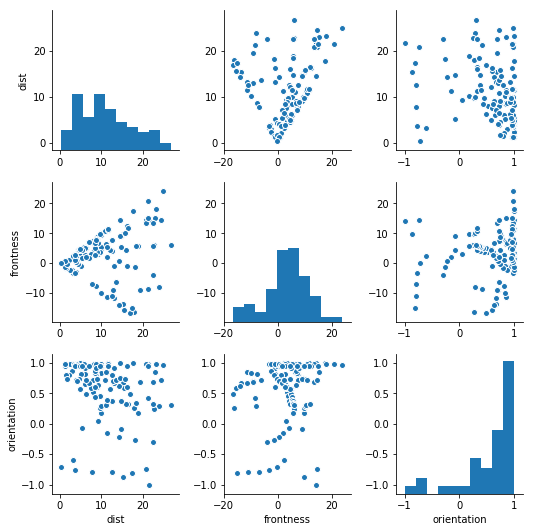

In [263]:
sns.pairplot(df)
plt.show()